In [3]:
# COMENZAMOS CON EL ENTRENAMIENTO DE LOS MODELOSfrom sklearn.model_selection import train_test_split

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sys import path
sys.path.append('C:\\Users\\Laura\\Desktop\\Nueva carpeta\\Code\\util')

from funciones import graficos_conf_matrix

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score,confusion_matrix,recall_score, f1_score
from sklearn.linear_model import LogisticRegression


from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import pickle


In [4]:
# IMPORTAMOS EL CSV YA LIMPIO .
# LO VAMOS A DIVIDIR EN DOS, UNA PARTE PARA EL ENTRENAMIENTO-PREDICCIONES Y OTRA PARTE PARA EL TEST, COMO SI DE DATOS REALES SE TRATARAN


data_train = pd.read_csv('../Data/Processed/data_processed.csv', index_col=0)

data_train = data_train.iloc[:int(data_train.shape[0]*60/100), :]
data_test = data_train.iloc[int(data_train.shape[0]*60/100) : , :]

In [9]:
# DIVIDIMOS EN DATA_TRAIN EN TRAIN Y TEST


X_train, X_test, y_train, y_test = train_test_split(data_train.drop(columns=['Target','Anxiety','Stress'], axis=1), data_train.Target, random_state=0, test_size=0.20, shuffle=True)



LOGISTIC REGRESION

In [ ]:
# CREACION DE PIPELINE INICIAL.
# HACEMOS UN GRIDSEARCH CON CROSS VALIDATIION
# LO INSTANCIAMOS
model_lr = Pipeline (steps = [
                     ('scaler', MinMaxScaler()),
                     ('lr', LogisticRegression())]
                    ) 


params = {'lr__penalty' : ['l1','l2','elasticnet'],
              'lr__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag'],
              'lr__max_iter': [100,200,300,400,500],
              'lr__C': [0.8,0.5,0.3]
            }


logistic_gtc = GridSearchCV(model_lr, params, cv=5, scoring='recall')
logistic_gtc.fit(X_train, y_train)

In [11]:
# SACAMOS LOS MEJORES PARÁMETROS PARA ENTRENAR EL MODELO

print (logistic_gtc.best_params_)
print (logistic_gtc.best_estimator_)

{'lr__C': 0.3, 'lr__max_iter': 100, 'lr__penalty': 'l2', 'lr__solver': 'newton-cg'}
Pipeline(steps=[('scaler', MinMaxScaler()),
                ('lr', LogisticRegression(C=0.3, solver='newton-cg'))])


In [12]:
#CREAMOS UN NUEVO PIPELINE CON EL RESULTADO MEJOR RESULTADO DEL GRIDSEARCH
model_lr_V0 = logistic_gtc.best_estimator_

In [13]:
# ENTRENAMOS EL MODELO Y SACAMOS LAS PREDICCIONES
model_lr_V0
model_lr_V0.fit(X_train,y_train)
y_predi = model_lr_V0.predict(X_test)

In [14]:
# PASAMOS LAS METRICAS A UN DATAFRAME MENO LA CONFUSION MATRIX
df_scores = {'log_re_data_train' :[recall_score(y_test,y_predi), roc_auc_score(y_test,y_predi),  accuracy_score(y_test, y_predi), f1_score(y_test, y_predi)]}
df_scores = pd.DataFrame(df_scores, index=['Recall','Auc','Accuracy', 'F1_score'])
df_scores

In [15]:
# GUARDAMOS LA CONFUSION MATRIX PARA DESPUES GRAFICARLA
c_matrix_train = confusion_matrix(y_test, y_predi)

In [16]:
# GUARDAMOS EL MODELO

with open('../Model/model_logist_V0', 'wb') as archivo_salida:
    pickle.dump(model_lr_V0, archivo_salida)


In [17]:
# PROBAMOS EL MODELO CON LOS DATOS RESERVADOS PARA VER COMO GENERALIZA

X = data_test.drop(columns=['Target','Anxiety','Stress'], axis=1)
y= data_test.Target

with open('../Model/model_logist_V0', 'rb') as archivo_entrada:
    loaded_model = pickle.load(archivo_entrada)

In [18]:
# PASAMOS LAS METRICAS A UN DATAFRAM
df_scores['log_re_test'] =[recall_score(y,loaded_model.predict(X)), roc_auc_score(y,loaded_model.predict(X)), accuracy_score(y, loaded_model.predict(X)), f1_score(y, loaded_model.predict(X))]
df_scores.to_csv('../Model/scores_models_Recall.csv')
df_scores

In [19]:
# GUARDAMOS LA CONFUSION MATRIX PARA DESPUES GRAFICARLA
c_matrix_test = confusion_matrix(y,loaded_model.predict(X))

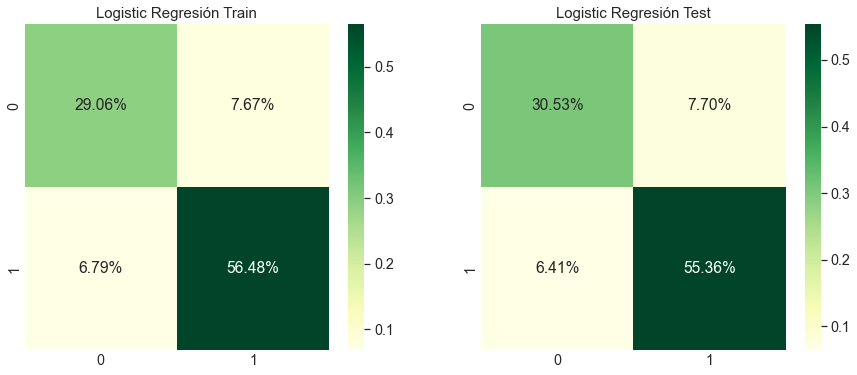

In [23]:
graf_lg_R_matriz = plt.figure(figsize=(15,6))

plt.style.use('seaborn-whitegrid')
plt.subplot(1,2,1)
sns.set(font_scale = 1.3)
graficos_conf_matrix(c_matrix_train,'Logistic Regresión Train')
plt.style.use('seaborn-whitegrid')
plt.subplot(1,2,2)
sns.set(font_scale = 1.3)
graficos_conf_matrix(c_matrix_test,'Logistic Regresión Test')

graf_lg_R_matriz.savefig ('../util/Graficos/graf_lg_R_matriz.png')